In [1]:
# %%
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
from numpy import genfromtxt
torch.set_default_dtype(torch.float64)

In [2]:
from torch.nn import functional as F
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# train
x = genfromtxt('data/mdata_train.txt', delimiter=',')
X_train = x.T
y_train = genfromtxt('data/mdata_train_l.txt',delimiter=',')

x_test = genfromtxt('data/mdata_test.txt', delimiter=',')
X_test = x_test.T
y_test = genfromtxt('data/mdata_test_l.txt',delimiter=',')

# Convert to torch
X_train = torch.tensor(X_train, dtype=torch.float64)
y_train = torch.tensor(y_train == 1, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test == 1, dtype=torch.long)

y_train = F.one_hot(y_train, num_classes=2).to(dtype=torch.float64)
y_test = F.one_hot(y_test, num_classes=2).to(dtype=torch.float64)

# Move data to GPU
X_train, y_train = X_train.cuda(), y_train.cuda()
X_test, y_test = X_test.cuda(), y_test.cuda()

# Prepare train input
xinp_train = torch.cat([torch.ones(X_train.shape[0], 1, dtype=X_train.dtype, device=X_train.device), X_train], dim=-1)
xinp_test = torch.cat([torch.ones(X_test.shape[0], 1, dtype=X_test.dtype, device=X_test.device), X_test], dim=-1)

In [3]:
from tensor.layers import TensorTrainLayer
from tensor.bregman import KLDivBregman, XEAutogradBregman
from sklearn.metrics import balanced_accuracy_score

N = 2
r = 5
p = X_train.shape[1]+1
C = y_train.shape[1]-1

def convergence_criterion(y_pred, y_true):
    y_pred = torch.cat((y_pred, torch.zeros_like(y_pred[:, :1])), dim=1)
    #accuracy = (y_pred.argmax(dim=-1) == y_true.argmax(dim=-1)).float().mean().item()
    balanced_acc = balanced_accuracy_score(y_true.argmax(dim=-1).cpu().numpy(), y_pred.argmax(dim=-1).cpu().numpy())
    print("Balanced Accuracy:", balanced_acc)
    #return accuracy > 0.95
    return False

# Define Bregman function
layer = TensorTrainLayer(N, r, p, output_shape=C).cuda()

In [4]:
layer.tensor_network.nodes

[TensorNode(name=A1, shape=torch.Size([1, 51, 5]), labels=['c1', 'p', 'r2']),
 TensorNode(name=A2, shape=torch.Size([5, 51]), labels=['r2', 'p']),
 TensorNode(name=X1, shape=torch.Size([1, 51]), labels=['s', 'p']),
 TensorNode(name=X2, shape=torch.Size([1, 51]), labels=['s', 'p'])]

In [5]:
with torch.inference_mode():
    y_pred = layer(xinp_train)
    w = 1/y_pred.std().item()
    del y_pred
bf = XEAutogradBregman(w=w)

layer.tensor_network.accumulating_swipe(xinp_train, y_train, bf, batch_size=-1, lr=0.8, convergence_criterion=convergence_criterion, orthonormalize=False, method='exact', eps=1e-4, verbose=1, num_swipes=100)

Left loss (A1): 0.7290983018588179
Balanced Accuracy: 0.6883609523108716
Left loss (A2): 0.5088324858660305
Balanced Accuracy: 0.7352611372921505
Right loss (A1): 0.42521333995195687
Balanced Accuracy: 0.7528259848778185
Left loss (A2): 0.39910049802268843
Balanced Accuracy: 0.7625280895808177
Right loss (A1): 0.38890110804510414
Balanced Accuracy: 0.7686680450915091
Left loss (A2): 0.38413975729671934
Balanced Accuracy: 0.7721145753845934
Right loss (A1): 0.38133850373696815
Balanced Accuracy: 0.774763802000495
Left loss (A2): 0.37789934358358407
Balanced Accuracy: 0.7764995078672534
Right loss (A1): 0.37685095758942766
Balanced Accuracy: 0.7774952185685915
Left loss (A2): 0.3748582248685407
Balanced Accuracy: 0.7787877629452298
Right loss (A1): 0.3737565788420981
Balanced Accuracy: 0.7793154067891056
Left loss (A2): 0.3721810631490808
Balanced Accuracy: 0.780572563266638
Right loss (A1): 0.37149301212683844
Balanced Accuracy: 0.7808295199473492
Left loss (A2): 0.37101807206920384
Bal

False

In [6]:
print("Train accuracy:")
convergence_criterion(layer(xinp_train), y_train)
print("Test accuracy:")
convergence_criterion(layer(xinp_test), y_test)
None

Train accuracy:
Balanced Accuracy: 0.7904827949189523
Test accuracy:
Balanced Accuracy: 0.8364468067517398


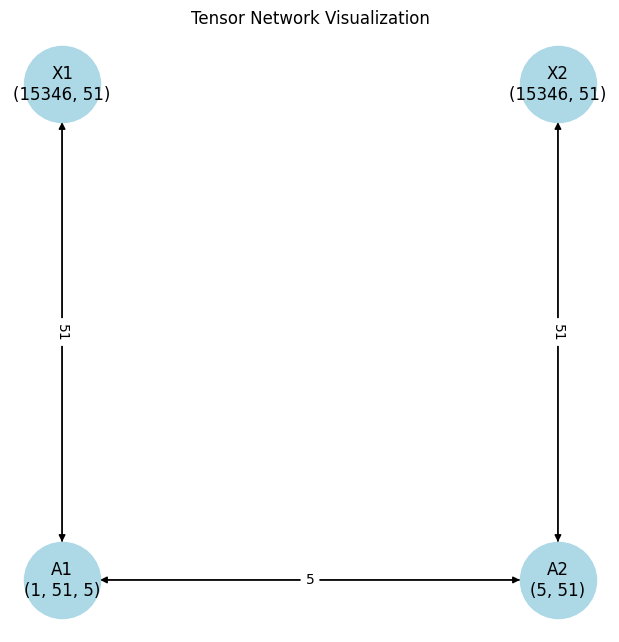

In [7]:
from tensor.utils import visualize_tensornetwork
visualize_tensornetwork(layer.tensor_network)